In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
from sqlalchemy import inspect

In [7]:
inspector = inspect(engine)

In [8]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect=True)

In [9]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [10]:
# use the inspector to find tables
inspector.get_table_names()

['measurement', 'station']

In [11]:
# Save references to each table
measurement = Base.classes.measurement
station = Base.classes.station

In [12]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [13]:
# use the inspector to get column names and types in measurement table
mcolumns = inspector.get_columns('measurement')
for column in mcolumns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [14]:
# use the inspector to get column names and types in station table
mcolumns = inspector.get_columns('station')
for column in mcolumns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


Retrieve the last 12 months of precipitation data and plot the results

In [15]:
# find the last date for precipitation data in the table
end_date = session.query(measurement.date).\
    order_by(measurement.date.desc()).first()

In [16]:
# print the first entry to determine what the last date in the 12 month dataset should be.
end_date

('2017-08-23')

In [17]:
#write a new query, pulling only 12 months of precipitation scores
year_data = session.query(measurement.date, measurement.prcp).\
    filter(measurement.date > '2016-08-23',).\
    order_by(measurement.date.desc()).all()

In [18]:
#unpack the "date" and "prcp" columns and save into lists
date = [result[0] for result in year_data]
precip = [result[1] for result in year_data]

In [19]:
# Save the query results as a Pandas DataFrame

PrecipDict = {
    "Date":date,
    "Precipitation":precip
}

precip_df = pd.DataFrame(PrecipDict)

# group by date and add precipitation so there is one entry per date, and index is set to the date column
precip_df = precip_df.groupby('Date').sum()
precip_df = precip_df.sort_values(by='Date', ascending=True)


In [20]:
precip_df.head()

,Precipitation
Date,
2016-08-24,9.33
2016-08-25,0.54
2016-08-26,0.10
2016-08-27,0.32
2016-08-28,3.10


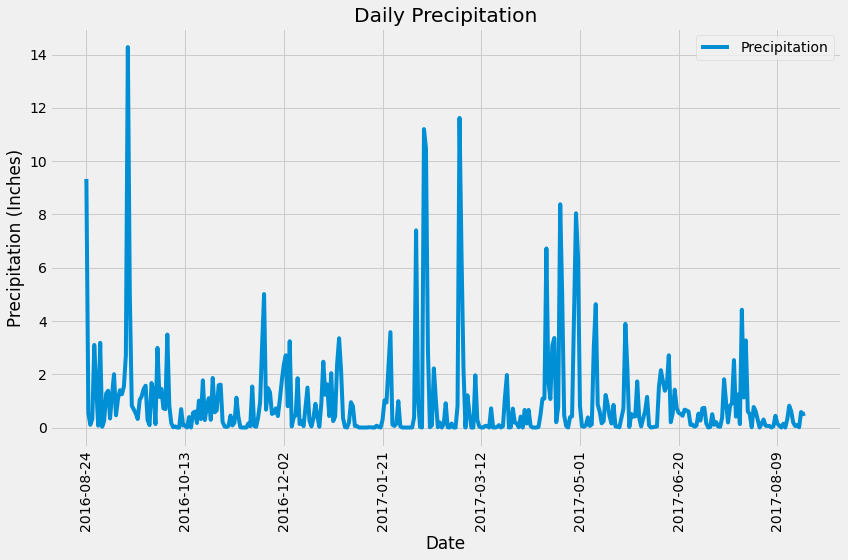

In [21]:
# Use Pandas Plotting with Matplotlib to plot the data
ax = precip_df.plot(figsize = (12, 8), rot=90)

# Set textual properties
plt.title("Daily Precipitation")
plt.ylabel("Precipitation (Inches)")
plt.xlabel("Date")
plt.tight_layout()
plt.show()

In [22]:
# Use Pandas to calcualte the summary statistics for the precipitation data
precip_df.describe()

,Precipitation
count,365.000000
mean,0.974164
std,1.776466
min,0.000000
25%,0.050000
50%,0.400000
75%,1.080000
max,14.280000


In [23]:
# use the inspector to get column names and types in station table
scolumns = inspector.get_columns('station')
for column in scolumns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [24]:
# Design a query to show how many stations are available in this dataset?
session.query(station.id).count()

9

In [25]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.

active_stations = session.query(measurement.station, func.count(measurement.date)).\
              group_by(measurement.station).order_by(func.count(measurement.date).desc())

In [26]:
for station in active_stations:
    (m_station, m_count) = station
    print(f'{m_station}:  {m_count}')

USC00519281:  2772
USC00519397:  2724
USC00513117:  2709
USC00519523:  2669
USC00516128:  2612
USC00514830:  2202
USC00511918:  1979
USC00517948:  1372
USC00518838:  511


In [27]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?

busy_station = 'USC00519281'

low_temp = session.query(func.min(measurement.tobs)).\
    filter(measurement.station == busy_station).all()

high_temp = session.query(func.max(measurement.tobs)).\
    filter(measurement.station == busy_station).all() 

avg_temp = session.query(func.avg(measurement.tobs)).\
    filter(measurement.station == busy_station).all() 

print(f'Temperature data for station {busy_station}:')
print(f'     High Temperature: {high_temp}')
print(f'     Low Temperature: {low_temp}')
print(f'     Average Temperature: {avg_temp}')

Temperature data for station USC00519281:
     High Temperature: [(85.0,)]
     Low Temperature: [(54.0,)]
     Average Temperature: [(71.66378066378067,)]


In [28]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

busy_year = session.query(measurement.tobs).\
    filter(measurement.date > '2016-08-23', measurement.station == busy_station).\
    order_by(measurement.date.desc()).all()


In [29]:
#unpack the "date" and "tobs" columns and save into lists
temps = [result[0] for result in busy_year]

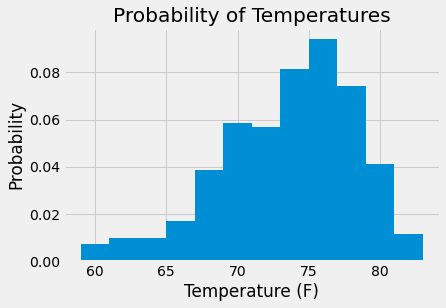

In [30]:
#plot on a histogram

plt.hist(temps, density = 1, bins=12)
plt.xlabel('Temperature (F)')
plt.ylabel('Probability')
plt.title('Probability of Temperatures')
plt.show()

## Bonus Challenge Assignment

In [31]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    return session.query(func.min(measurement.tobs), func.avg(measurement.tobs), func.max(measurement.tobs)).\
        filter(measurement.date >= start_date).filter(measurement.date <= end_date).all()

# function usage example
temps2012 = calc_temps('2012-02-28', '2012-03-05')

print(temps2012)

[(62.0, 69.57142857142857, 74.0)]


In [32]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.

temps2011 = calc_temps('2012-02-28', '2012-03-05')

print(temps2011)

[(62.0, 69.57142857142857, 74.0)]


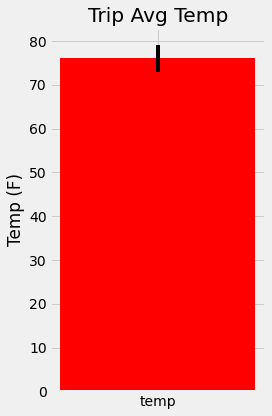

In [55]:
# Plot the results from your previous query as a bar chart. 
min = temps[0]
avg = temps[1]
max = temps[2]

# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
error = max - min

label = ['temp']
x_axis = np.arange(len(label))

plt.figure(figsize = (4, 6))

plt.bar(x_axis, avg, yerr = error, color='r', align='center')

ticks = [value for value in x_axis]
plt.xticks(ticks, label)

plt.title('Trip Avg Temp')
plt.ylabel('Temp (F)')

plt.tight_layout()
plt.show()




In [ ]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



In [ ]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

In [ ]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`
